In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## 0. Загрузка данных

In [3]:
!pip install mne
!wget https://raw.githubusercontent.com/adasegroup/NEUROML2020/seminar1/seminar1/train.csv
!wget https://raw.githubusercontent.com/adasegroup/NEUROML2020/seminar1/seminar1/test.csv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 54.4 MB/s eta 0:00:00
--2025-12-14 23:36:12--  https://raw.githubusercontent.com/adasegroup/NEUROML2020/seminar1/seminar1/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5381138 (5.1M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   5.13M  --.-KB/s    in 0.08s   

2025-12-14 23:36:12 (65.9 MB/s) - ‘train.csv’ saved [5381138/5381138]

--2025-12-14 23:36:12--  https://raw.githubusercontent.com/adasegroup/NEUROML2020/seminar1/seminar1/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connec

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import mne

delimiter = "\n"+"-"*10

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,time,condition,epoch,C3,Cz,C4,Fp1,Fp2,F7,F3,...,F8,T7,T8,P7,P3,Pz,P4,P8,O1,O2
0,0,1,0,-5.885714,-2.533107,9.866895,7.962973,5.694433,23.638605,27.899784,...,23.588723,12.178548,0.685809,-4.887397,-10.646985,-14.735646,-8.729323,-0.562578,-17.055458,-3.616732
1,1,1,0,-7.999715,-16.916729,-11.924855,17.955477,8.526994,56.635981,28.508435,...,1.045533,14.656061,-4.119778,-4.632381,-17.980657,-23.456960,-12.960684,-9.639784,-20.233549,-1.229811
2,2,1,0,-6.727283,-15.979567,-11.114195,17.183478,4.497028,43.914130,10.079754,...,-14.741630,14.793562,-6.624813,-3.402757,-10.269473,-18.736144,-3.579046,-0.045658,-14.089755,2.453398
3,3,1,0,6.819390,-0.204905,10.090124,20.265222,7.843006,36.250611,13.291199,...,-7.135541,21.723418,-2.276825,2.066859,4.325365,-2.803322,8.835114,13.878945,-5.772410,7.657873
4,4,1,0,13.129486,-5.817193,5.040633,19.462210,9.634234,42.311729,20.641012,...,0.015602,19.703190,3.739076,2.714350,3.251047,-3.631448,3.212956,4.635574,-5.045448,5.086024


Описание датасета из Kaggle:
```
You have to predict probability of fist motion on EEG record

Evaluation
Your metric will be ROC-AUC

Target
You have to prepare target column yourself. Look for condition field in train/test dataset. 1 is resting state (expected = 0), 2 and 3 are hand motions. (expected = 1)
```
Посмотрим на таргет:

In [6]:
print("Состояния: ", df_train['condition'].unique())

df_train['target'] = df_train['condition'].apply(lambda x: 0 if x == 1 else 1)
print("Таргет: \n", df_train['target'])

Состояния:  [1 2 3]
Таргет: 
 0        0
1        0
2        0
3        0
4        0
        ..
14575    0
14576    0
14577    0
14578    0
14579    0
Name: target, Length: 14580, dtype: int64


Таким образом у нас задача бинарной классификации.

## 1. Анализ целевой переменной
[0.5] Численный анализ:

~~Для регрессии: распределение таргета, поиск аномальных значений~~

Для классификации: распределение количества классов

[0.5] Визуализация статистик:
- Изолированный анализ
- Анализ во временном контексте

#### 1.1 Изолированный анализ

In [47]:
print("Распределение количества классов прокси-таргета (все данные внутри эпох): \n", df_train['condition'].value_counts())
print("Распределение количества классов таргета (все данные внутри эпох): \n", df_train['condition'].apply(lambda x: 0 if x == 1 else 1).value_counts())

Распределение количества классов прокси-таргета (все данные внутри эпох): 
 condition
1    7290
2    3645
3    3645
Name: count, dtype: int64
Распределение количества классов таргета (все данные внутри эпох): 
 condition
0    7290
1    7290
Name: count, dtype: int64


Количество пропущенных значений в таргете
0 
----------
Есть ли бесконечности в данных?
False 
----------


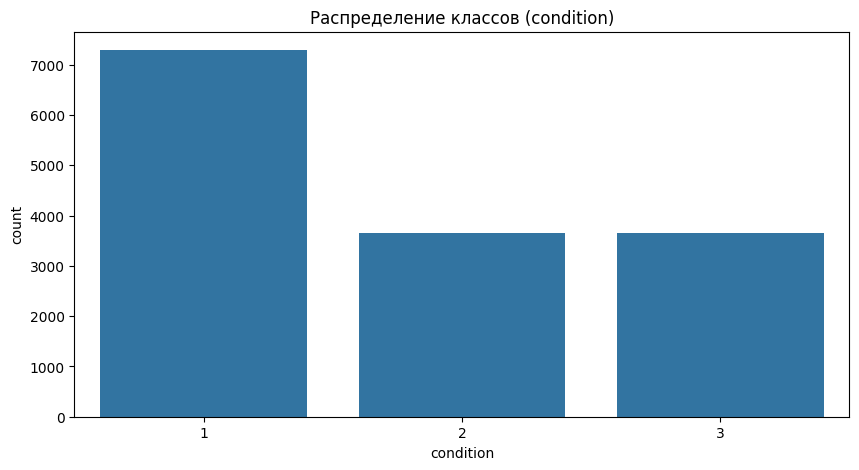

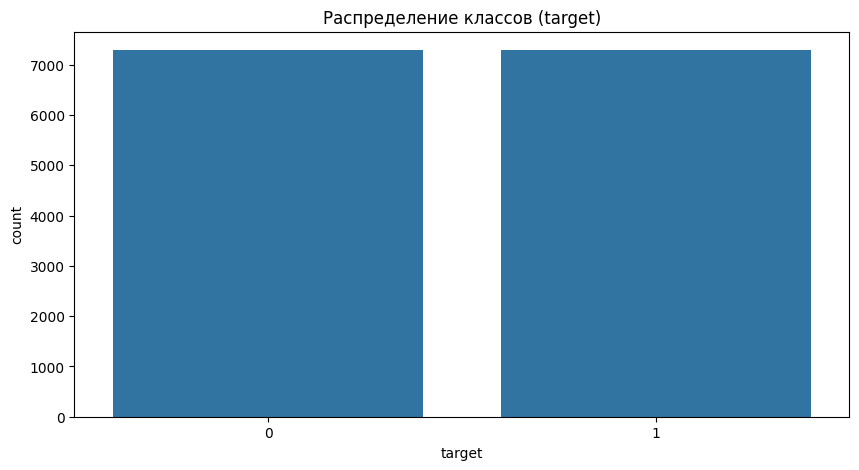

In [34]:
print("Количество пропущенных значений в таргете")
print(df_train['target'].isnull().sum(), delimiter)

print("Есть ли бесконечности в данных?")
print(np.isinf(df_train['target'].values).any(), delimiter)

plt.figure(figsize=(10, 5))
sns.countplot(x='condition', data=df_train)
plt.title('Распределение классов (condition)')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='target', data=df_train)
plt.title('Распределение классов (target)')
plt.show()

In [48]:
X = df_train.drop_duplicates('epoch')[['epoch', 'condition']].reset_index(drop=True)
y = X['condition'].apply(lambda x: 0 if x == 1 else 1)

# Таргет для обучения по эпохам
print("Распределение количества классов прокси-таргета для обучения по эпохам (после объединения): \n", X['condition'].value_counts())
print("Распределение количества классов таргета для обучения по эпохам (после объединения): \n", y.value_counts())

Распределение количества классов прокси-таргета для обучения по эпохам (после объединения): 
 condition
1    90
2    45
3    45
Name: count, dtype: int64
Распределение количества классов таргета для обучения по эпохам (после объединения): 
 condition
0    90
1    90
Name: count, dtype: int64


#### 1.2 Анализ во временном контексте
Сам по себе бинарный таргет в контексте ЭЭГ нет большого смысла рассматривать по времени - поэтому посмотрим на показания активностей точек (каналов) на мозге.

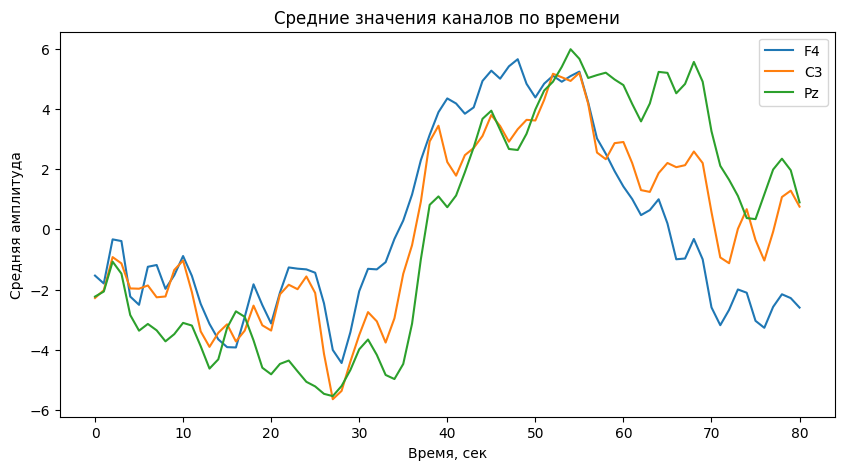

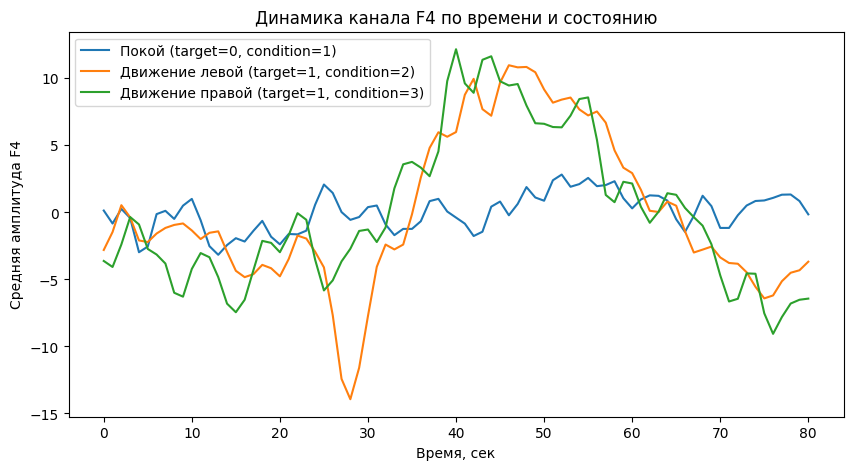

In [27]:
channels_for_analysis = ['F4', 'C3', 'Pz'] ### показательные классы с точки зрения активности мозга

plt.figure(figsize=(10, 5))
for ch in channels_for_analysis:
    plt.plot(
        df_train.groupby('time')[ch].mean(),
        label=ch
    )
plt.xlabel('Время, сек')
plt.ylabel('Средняя амплитуда')
plt.title('Средние значения каналов по времени')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for cond, name in zip([1,2,3], ['Покой (target=0, condition=1)', 'Движение левой (target=1, condition=2)', 'Движение правой (target=1, condition=3)']):
    plt.plot(
        df_train[df_train['condition']==cond].groupby('time')['F4'].mean(),
        label=name
    )
plt.xlabel('Время, сек')
plt.ylabel('Средняя амплитуда F4')
plt.title('Динамика канала F4 по времени и состоянию')
plt.legend()
plt.show()


In [21]:
non_eeg = ['time', 'condition', 'epoch', 'target']
channels = [ch for ch in df_train.columns if ch not in non_eeg]
print("Каналы: ", channels)

# Сгенерируем случайное среднее по каждому каналу
mean_values = df_train[channels].mean().values

print("Информация по записи активности:")
info = mne.create_info(ch_names=channels, sfreq=250, ch_types='eeg')
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

Каналы:  ['C3', 'Cz', 'C4', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']
Информация по записи активности:


<Info | 8 non-empty values
 bads: []
 ch_names: C3, Cz, C4, Fp1, Fp2, F7, F3, Fz, F4, F8, T7, T8, P7, P3, Pz, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 250.0 Hz
>

Creating RawArray with float64 data, n_channels=19, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


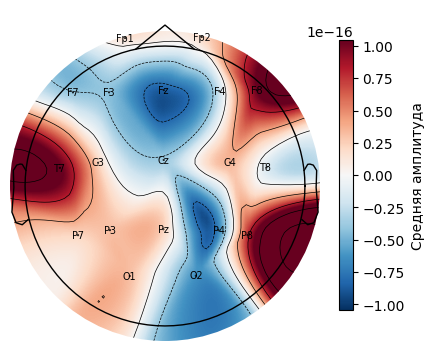

In [22]:
raw = mne.io.RawArray(mean_values.reshape(-1, 1), info)

fig, ax = plt.subplots(figsize=(5, 5))
im, _ = mne.viz.plot_topomap(mean_values, pos=info, axes=ax, names=channels, show=False)
fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7, label='Средняя амплитуда')

Топомапа выше показывает распределение средней амплитуды сигнала ЭЭГ по всем электродам в соответствии с их расположениюем на голове по стандартной схеме.

Видно, в каких областях наблюдается максимальная или минимальная средняя активность.
Для нашего таргета "покой/движение" топомапа особенно полезна для быстрой оценки пространственных паттернов и поиска аномалий или фокусов активности.

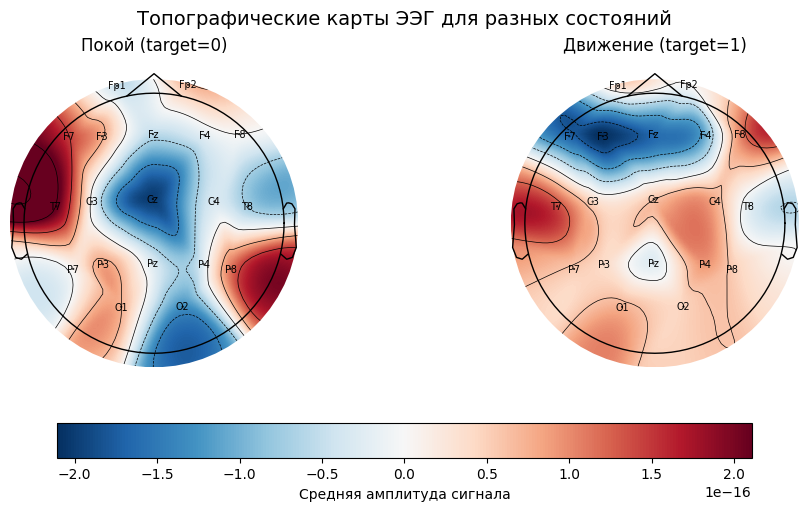

In [23]:
### Посмотрим на топографию активности в зависимости от таргета
mean_rest = df_train[df_train['target'] == 0][channels].mean().values
mean_move = df_train[df_train['target'] == 1][channels].mean().values

info = mne.create_info(ch_names=channels, sfreq=250, ch_types='eeg')
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

for mean_vals, label, ax in zip(
        [mean_rest, mean_move],
        ['Покой (target=0)', 'Движение (target=1)'],
        axes):
    im, _ = mne.viz.plot_topomap(mean_vals, info, axes=ax, names=channels, show=False)
    ax.set_title(label, fontsize=12)

fig.colorbar(im, ax=axes, orientation='horizontal', shrink=0.7, pad=0.15, label='Средняя амплитуда сигнала')
plt.suptitle("Топографические карты ЭЭГ для разных состояний", fontsize=14)
plt.show()


**Частично реализовано выше ^^^**
## 2. Анализ признаков (максимум 4 балла)

[0.5] Типизация признаков (числовые, категориальные, временные) и их распределения

[0.5] Выявление аномальных значений

[0.5] Анализ зависимостей между признаками

[0.5] Анализ пропущенных значений

[0.5] Определение важности признаков (корреляции с таргетом)

[1.0] Графическая визуализация минимум 3-х пунктов выше

[0.5] Анализ возможных преобразований и генерации новых признаков

Типы признаков:
time       int64
epoch      int64
C3       float64
Cz       float64
C4       float64
Fp1      float64
Fp2      float64
F7       float64
F3       float64
Fz       float64
F4       float64
F8       float64
T7       float64
T8       float64
P7       float64
P3       float64
Pz       float64
P4       float64
P8       float64
O1       float64
O2       float64
dtype: object 

Категориальные признаки: ['epoch']
Временные признаки: ['time']
Числовые признаки: ['C3', 'Cz', 'C4', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2'] 



<Figure size 1000x1000 with 0 Axes>

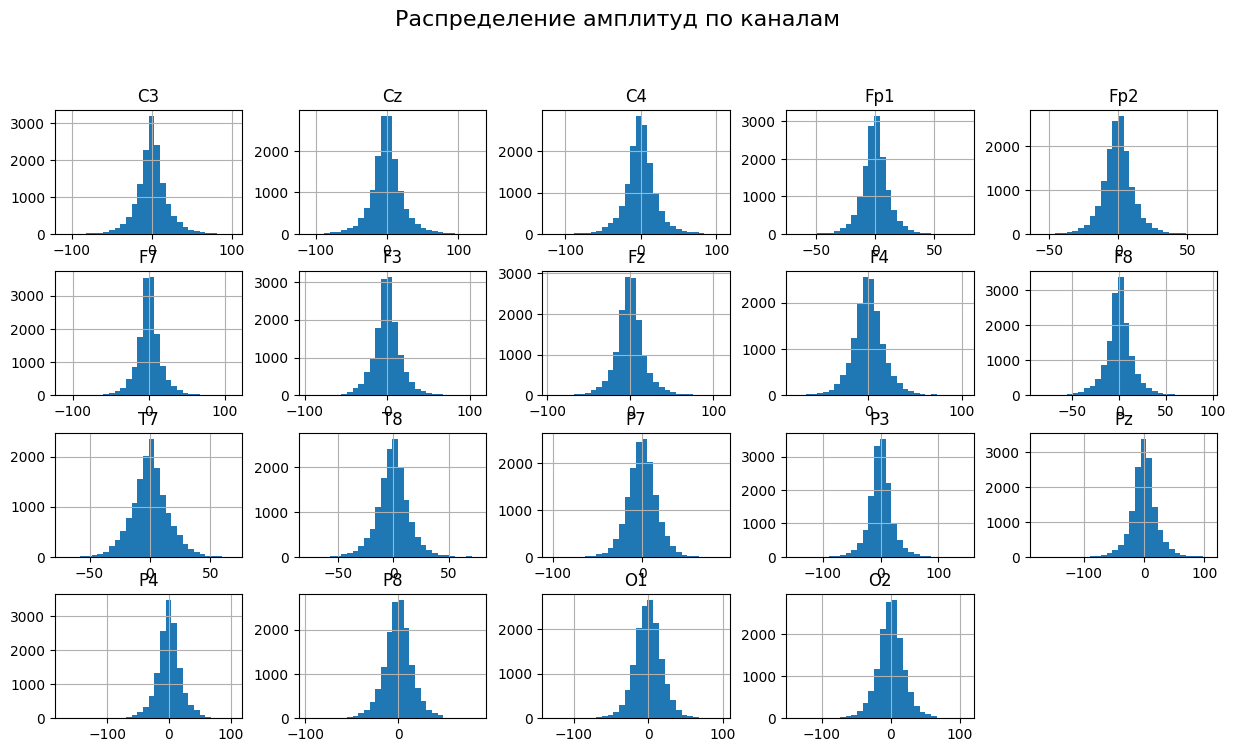

In [24]:
df_features = df_train.drop(columns=['condition', 'target'], axis=1)

# Типизация признаков (числовые, категориальные, временные) и их распределения
print("Типы признаков:")
print(df_features.dtypes, '\n')

# руками:
categorical = ['epoch']
time_feature = ['time']
numerical = [c for c in df_features.columns if c not in categorical+time_feature]
print("Категориальные признаки:", categorical)
print("Временные признаки:", time_feature)
print("Числовые признаки:", numerical, '\n')

# Распределение каналов
plt.figure(figsize=(10,10))
df_features[channels].hist(bins=30, figsize=(15, 10), layout=(5, 5))
plt.suptitle('Распределение амплитуд по каналам', fontsize=16)
plt.show()


In [37]:
# Выявление аномальных значений + анализ пропущенных значений
print('Пропущенных значений: \n', df_features.isnull().sum().sum(), delimiter)
print('Есть ли бесконечности: \n', np.isinf(df_features[channels].values).any(), delimiter)

print("Количество пропущенных значений в каждом столбце: \n", df_features.isnull().sum(), delimiter)

print("Минимумы и максимумы по каналам: \n", df_features[channels].describe().T[['min', 'max']], delimiter)

desc = df_features[channels].describe().T
outlier_cnt = (np.abs(df_features[channels] - desc['mean']) > 5*desc['std']).sum().sum()
print(f'Число экстремальных выбросов (>5σ): \n{outlier_cnt}')


Пропущенных значений: 
 0 
----------
Есть ли бесконечности: 
 False 
----------
Количество пропущенных значений в каждом столбце: 
 time     0
epoch    0
C3       0
Cz       0
C4       0
Fp1      0
Fp2      0
F7       0
F3       0
Fz       0
F4       0
F8       0
T7       0
T8       0
P7       0
P3       0
Pz       0
P4       0
P8       0
O1       0
O2       0
dtype: int64 
----------
Минимумы и максимумы по каналам: 
             min         max
C3  -110.586954  102.425351
Cz  -111.786668  127.017032
C4  -119.021961  106.631059
Fp1  -68.015795   75.826919
Fp2  -57.589380   65.569247
F7  -112.107122  111.488149
F3   -97.016038  109.686695
Fz   -95.482079  109.557200
F4   -79.088062  103.443666
F8   -86.151925   95.553852
T7   -71.665649   69.387517
T8   -77.540110   76.130631
P7  -102.147259   88.560250
P3  -148.858104  146.162288
Pz  -175.457334  107.350710
P4  -170.935519  104.908612
P8   -97.977127   85.434132
O1  -130.620573   98.393705
O2  -139.820427  107.972063 
----------
Числ

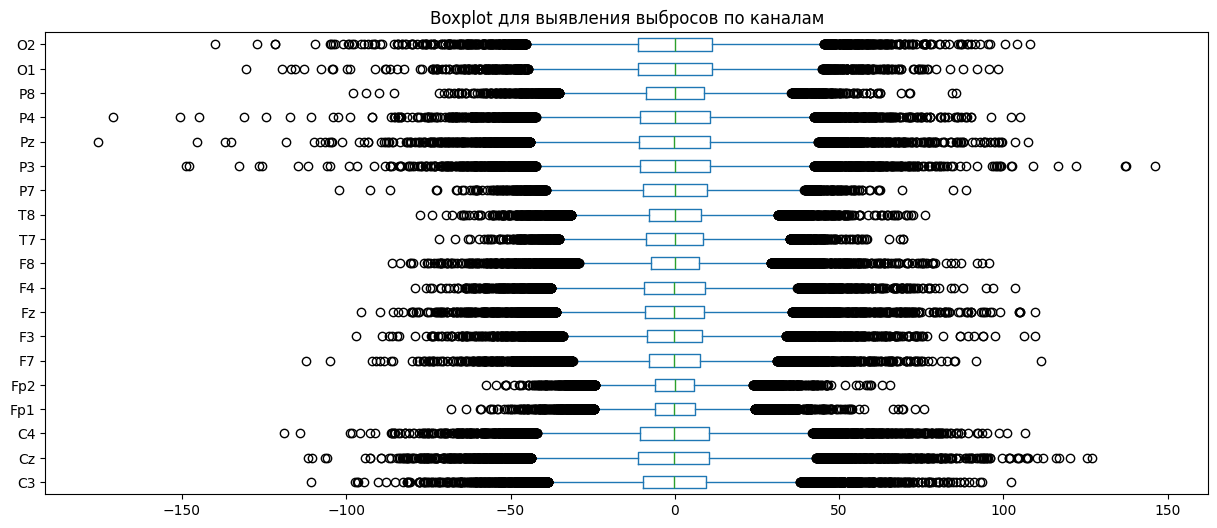

In [36]:
df_train[numerical].plot(kind="box", figsize=(15,6), vert=False)
plt.title('Boxplot для выявления выбросов по каналам')
plt.show()


У *P8-P3* самые длинные "усы" boxplot'а, но при этом (исходя из min/max'ов) данные все еще находятся в нормальном физическом диапазоне и их удаление может привести к потере важной информации из ЭЭГ.

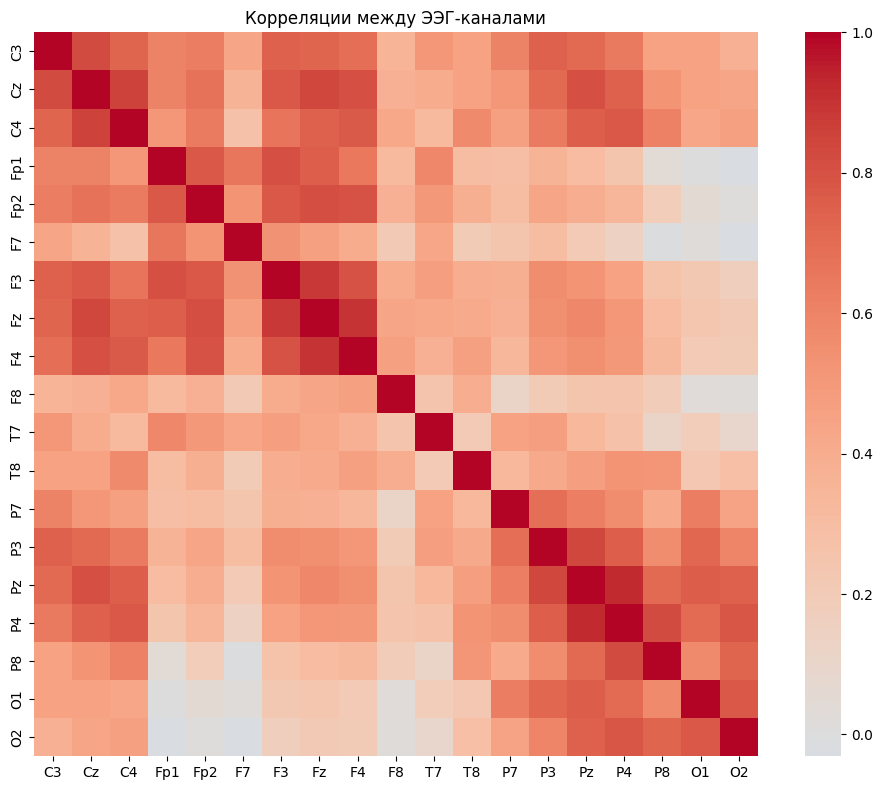

In [38]:
# Анализ зависимостей между признаками
corr = df_train[channels].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True)
plt.title('Корреляции между ЭЭГ-каналами')
plt.tight_layout()
plt.show()


In [45]:
# численные корреляции:
corr = df_train[channels].corr()
corr_triu = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr_pairs = corr_triu.stack().reset_index()
corr_pairs.columns = ['channel_1', 'channel_2', 'correlation']
top10 = corr_pairs.reindex(corr_pairs['correlation'].abs().sort_values(ascending=False).index).head(10)
print("Топ-6 наиболее скоррелированных пар каналов (по модулю): \n", top10)

Топ-6 наиболее скоррелированных пар каналов (по модулю): 
     channel_1 channel_2  correlation
161        Pz        P4     0.925577
105        Fz        F4     0.902868
93         F3        Fz     0.885465
18         Cz        C4     0.854347
23         Cz        Fz     0.842129
156        P3        Pz     0.835070
165        P4        P8     0.826602
0          C3        Cz     0.822357
68        Fp2        Fz     0.813425
30         Cz        Pz     0.803092


Тут логично видно, что, например, фронтальные каналы (начинаются на F) коррелируют между собой, потому что находятся на голове физически близко друг к другу.

Т.е. в целом логично, что **каналы, находящиеся близко на голове, обычно сильнее коррелируют.**

O2    9.901833e-18
F8    9.893771e-18
Pz    9.834707e-18
Cz    7.241734e-18
F4    2.947453e-18
dtype: float64


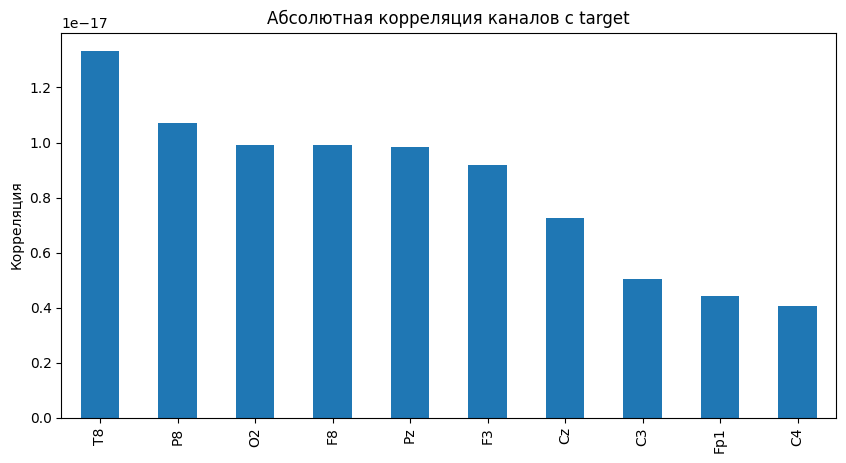

In [41]:
# Определение важности признаков (корреляции с таргетом)

target_corr = df_train[channels].corrwith(df_train['target']).sort_values(ascending=False)
print(target_corr.head())

# Топ 10
plt.figure(figsize=(10,5))
target_corr.abs().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Абсолютная корреляция каналов с target')
plt.ylabel('Корреляция')
plt.show()



**Анализ возможных преобразований и генерации новых признаков**

Если посмотреть на матрицу корреляций, можно было бы предложить интерполировать F-каналы в 1 точку, P-каналы в 1 точку и C-каналы в точку 1 (т.е. свести число каналов с 19 до 19-2-2-2=13 интерполяцией), но в случае ЭЭГ это может привести к частичной потере информации.

Почему? На практике модели по ЭЭГ обучаются МИНИМУМ на 16 каналах, а вообще говоря для хорошего результата требуется 20+ каналов, потому что засчет специфичного распределения на голове на самом деле каждый канал имеет свою уникальную важную информацию **в разный момент времени**.

В идеале было бы весь мозг усыпать датчиками, чтобы улавшивать активность каждого участка мозга, но это тяжело реализуемо.

Поэтому пока оставляем все признаки на месте, но будем помнить про F-..., C-... и P-... каналы.

---

### Выводы

Однако есть смысл реализовать создание новых признаков, которые отражают важные особенности ЭЭГ-сигнала и могут быть полезны для классификации.

Например, функцию `calc_features`, которая будет для каждой эпохи стоить:

- **Относительную мощность β-ритма** по каждому каналу — это диапазон частот, тесно связанный с движением и активностью мозга.
- **P300-подобная фича** — сколько раз амплитуда сигнала в канале превышает порог после определенного времени, что может указывать на реакции мозга на события или стимулы.

Использование таких осмысленных признаков помогает моделям лучше различать состояния "покой" и "движение", так как эти характеристики тесно связаны с биологическими процессами в мозге.

Таким образом, вместо простого усреднения или уменьшения количества каналов, мы добавляем информативные биомаркеры, что может существенно повысить качество работы модели.

См ниже:

In [57]:
def get_target(df):
    # берем по одной строке для каждой эпохи, оставляем только столбцы epoch и condition
    res = df.drop_duplicates('epoch')[['epoch', 'condition']].reset_index(drop=True)
    return res


def calc_features(df, channels=channels):
    """
    Генерируем числовые признаки для каждой эпохи на основе EEG:
        - Спектральная мощность бета-ритма (13-25 Гц) по каждому каналу
        - P300-like фича: количество "сильных" срабатываний (>5) на интервале после 40-й точки по каналу
    """
    feats = []
    for epoch_idx, epoch_df in df.groupby('epoch'):
        epoch_df = epoch_df[channels]

        # считаем psd по каждому каналу
        psds, freqs = psd_array_multitaper(epoch_df.T.values, 160, verbose=False)

        total_power = psds.sum(axis=1)

        # находим индексы бета-диапазона
        idx_from = np.where(freqs > 13)[0][0]
        idx_to = np.where(freqs > 25)[0][0]
        b_pwr = psds[:, idx_from:idx_to].sum(axis=1) / total_power

        d = {}
        d['epoch'] = epoch_idx  # идентификатор эпохи

        # P300
        for ch in channels:
            s = epoch_df.iloc[40:][ch]
            val = (s > 5).sum()
            d[ch.lower() + '_p300'] = val  # добавляем в фичи

        feats.append(d)

    feats_df = pd.DataFrame(feats)
    return feats_df


In [58]:
from mne.time_frequency import psd_array_multitaper

X = get_target(df_train)
X = X.merge(calc_features(df_train, channels), on='epoch')
y = X['condition'].apply(lambda x: 0 if x == 1 else 1)
del X['epoch']
del X['condition']


In [59]:
X

,c3_p300,cz_p300,c4_p300,fp1_p300,fp2_p300,f7_p300,f3_p300,fz_p300,f4_p300,f8_p300,t7_p300,t8_p300,p7_p300,p3_p300,pz_p300,p4_p300,p8_p300,o1_p300,o2_p300
0,10,20,21,2,5,4,9,20,21,16,2,9,12,22,24,22,19,27,25
1,19,18,18,18,18,18,18,19,18,18,12,19,19,20,18,17,18,18,17
2,7,9,12,6,8,12,10,8,16,9,5,10,32,28,24,19,20,23,19
3,9,15,17,6,10,17,17,14,12,19,9,10,7,8,17,17,22,8,10
4,7,8,12,6,8,20,7,8,10,12,7,8,7,11,9,10,13,15,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,12,15,9,9,4,6,11,11,12,4,7,7,16,11,10,12,18,23,22
176,11,9,8,11,11,9,7,7,5,11,14,8,12,12,14,15,14,15,16
177,15,14,15,15,14,13,13,12,12,10,12,14,16,16,13,13,15,17,16
178,29,21,18,23,17,35,31,21,19,22,31,18,33,26,24,24,23,31,28


In [60]:
y

,condition
0,0
1,1
2,1
3,0
4,0
...,...
175,1
176,0
177,0
178,1


Нужные функции для препроцессинга перенесла в `src`.